In [1]:
!pip install transformers datasets

In [2]:
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

File ‘AirlineTweets.csv’ already there; not retrieving.



In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv("AirlineTweets.csv")

In [5]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
df = df[['airline_sentiment', 'text']].copy()

In [7]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

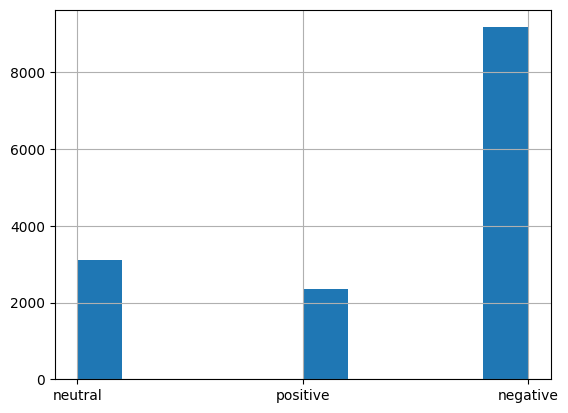

In [8]:
df.airline_sentiment.hist()

In [9]:
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

In [10]:
df2 = df[['text', 'target']]
df2.columns = ['sentence', 'label']
df2.to_csv('data.csv', index=None)

In [11]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [12]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='data.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [13]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [14]:
split = raw_dataset['train'].train_test_split(test_size=.3, seed=42)

In [15]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [16]:
# if there are multinle csv files
# load_dataset('csv',  data_files=['file1.csv', 'file2.csv'])

In [17]:
# if there is already train test split
# load_dataset('csv',  data_files={
#                                   'train': ['file1.csv', 'file2.csv'],
#                                   'test': 'test.csv'
#                                  })

In [18]:
checkpoint = 'distilbert-base-cased'

In [19]:
from transformers import AutoTokenizer

In [20]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [21]:
def tokenize_fn(batch):
    return tokenizer(batch['sentence'], truncation=True)

In [22]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [23]:
from transformers import AutoModelForSequenceClassification, \
    AutoConfig, Trainer, TrainingArguments

In [24]:
config = AutoConfig.from_pretrained(checkpoint)

In [25]:
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.34.1",
  "vocab_size": 28996
}

In [26]:
config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [27]:
config.label2id

{'LABEL_0': 0, 'LABEL_1': 1}

In [28]:
config.id2label = {v:k for k,v in target_map.items()}
config.label2id = target_map

In [29]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, config=config)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
!pip install torchinfo

In [31]:
from torchinfo import summary

In [32]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [33]:
!pip install torch==1.13.1

In [34]:
!pip install transformers[torch]

In [35]:
!pip install accelerate -U

In [36]:
training_args = TrainingArguments(
    output_dir='training_dir',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64
)

In [37]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions==labels)
    f1 = f1_score(labels, predictions, average='macro')
    return {'accuracy': acc, 'f1': f1}

In [38]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [39]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.539100,0.420660,0.834699,0.776763
2,0.346000,0.484846,0.833561,0.771480
3,0.223800,0.646928,0.838342,0.785675


TrainOutput(global_step=1923, training_loss=0.32206626491378015, metrics={'train_runtime': 222.2506, 'train_samples_per_second': 138.33, 'train_steps_per_second': 8.652, 'total_flos': 387616869956304.0, 'train_loss': 0.32206626491378015, 'epoch': 3.0})

In [40]:
!ls training_dir

checkpoint-1282  checkpoint-1923  checkpoint-641  runs


In [41]:
from transformers import pipeline

In [42]:
savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-1282',
                      device=0)

In [43]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [44]:
test_pred = savedmodel(split['test']['sentence'])

In [45]:
test_pred

[{'label': 'positive', 'score': 0.9693740010261536},
 {'label': 'positive', 'score': 0.9736958742141724},
 {'label': 'positive', 'score': 0.9010999798774719},
 {'label': 'positive', 'score': 0.9375857710838318},
 {'label': 'neutral', 'score': 0.7082529067993164},
 {'label': 'negative', 'score': 0.9966080188751221},
 {'label': 'neutral', 'score': 0.764549195766449},
 {'label': 'neutral', 'score': 0.7137510180473328},
 {'label': 'positive', 'score': 0.9404456615447998},
 {'label': 'negative', 'score': 0.9942637085914612},
 {'label': 'negative', 'score': 0.9883934855461121},
 {'label': 'negative', 'score': 0.995270311832428},
 {'label': 'positive', 'score': 0.9474258422851562},
 {'label': 'negative', 'score': 0.994462788105011},
 {'label': 'neutral', 'score': 0.976239800453186},
 {'label': 'neutral', 'score': 0.761513888835907},
 {'label': 'negative', 'score': 0.6422183513641357},
 {'label': 'negative', 'score': 0.9961852431297302},
 {'label': 'negative', 'score': 0.9176755547523499},
 {'